<a href="https://colab.research.google.com/github/Aarsh01/Sentiment_Analysis/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'sentiment-analysis-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F989445%2F1808590%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240203%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240203T205312Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D30fc9868f4eb430ba31ae0e63588fe6c3643fd12c71b917eb2f6f2bf378384bdc0a76a6b6bc1bcc2ad811737b8e15c652635535a451838721f0ff21639fbbcb4c0a80df92b7aefc9a787b5833d1eb7ad5fa477299454e8aadb6484075f9233869f2d868f530514cea250e2e11c470b0bc6b60aaccf8acb09d66559b00821d7f88f142a2265624b5f58443e66f88ca39e2fc22de5bb19cfa17e338d837973fe076e99c06825d3479fc51b026d2d78542bd80e2ed10a24f2967b344c0298b11862f09ed3503c07f34d44211a24da9e8cdae264b50e9a8907351abdedeebb067e2f9d8c0603fe34b2f0bc11751a2c7fd89b2b79e50a81c848a50eaed8df0424af7c'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 57092644 bytes downloaded
Downloaded and uncompressed: sentiment-analysis-dataset
Data source import complete.


## Twitter Sentiment Analysis

In [20]:
import nltk
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> all


       | 
       | Downloading package abc to /root/nltk_data...
       |   Unzipping corpora/abc.zip.
       | Downloading package alpino to /root/nltk_data...
       |   Unzipping corpora/alpino.zip.
       | Downloading package averaged_perceptron_tagger to
       |     /root/nltk_data...
       |   Unzipping taggers/averaged_perceptron_tagger.zip.
       | Downloading package averaged_perceptron_tagger_ru to
       |     /root/nltk_data...
       |   Unzipping taggers/averaged_perceptron_tagger_ru.zip.
       | Downloading package basque_grammars to /root/nltk_data...
       |   Unzipping grammars/basque_grammars.zip.
       | Downloading package bcp47 to /root/nltk_data...
       | Downloading package biocreative_ppi to /root/nltk_data...
       |   Unzipping corpora/biocreative_ppi.zip.
       | Downloading package bllip_wsj_no_aux to /root/nltk_data...
       |   Unzipping models/bllip_wsj_no_aux.zip.
       | Downloading package book_grammars to /root/nltk_data...
       |   Un


---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


True

In [5]:


import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from string import punctuation
from nltk.tokenize import word_tokenize
from nltk.stem import LancasterStemmer
from string import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import LancasterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import re
import warnings
warnings.filterwarnings('ignore')

## Dataset

In [6]:
df = pd.read_csv('/kaggle/input/sentiment-analysis-dataset/training.1600000.processed.noemoticon.csv',
                 delimiter=',', encoding='ISO-8859-1')
df.columns = ['Sentiment','id','date','query','user','text']
df.head()

,Sentiment,id,date,query,user,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [7]:
df = df[['Sentiment','text']]

In [8]:
df.columns

Index(['Sentiment', 'text'], dtype='object')

In [9]:
df.Sentiment.value_counts()

0    799996
4    248576
Name: Sentiment, dtype: int64

In [10]:
df['Sentiment'] = df['Sentiment'].replace({4:1})

* 0 represent Negative sentiment
* 1 represents Positive sentiment

#### Visualizing the count

In [11]:
# sns.countplot(df["Sentiment"])
# plt.title("Count Plot of Sentiment")
# plt.show()

In [12]:
df.isna().sum().sum()

0

**Inference: The data is unbalanced therfore we will downsample the data to have same count for each sentiment**

## Downsampling the dataset

In [13]:
from sklearn.utils import resample

In [14]:
## majority class 0
df_majority = df[df['Sentiment']==0]
## minority class 1
df_minority = df[df['Sentiment']==1]

In [15]:
df_minority.shape

(248576, 2)

In [16]:
# downsample the majority class
df_majority_downsampled = resample(df_majority,
                                 replace=False,
                                 n_samples=len(df_minority),
                                 random_state=1234)

In [17]:
df = df_majority_downsampled.append(df_minority)
df.head()

,Sentiment,text
74567,0,Wow slept for almost 12hours. Sleepy me!! Uni ...
668722,0,gets bored with an idea too easily ... like tw...
286706,0,To my girls - sorry i've been a homebody latel...
632911,0,BK once again for the weekend...If it wasnt fo...
356735,0,@DonnieWahlberg Now why didn't you do that las...


#### Visualizing after downsampling

248576 data for each class

In [18]:
# sns.countplot(df["Sentiment"])
# plt.title("Count Plot of target class")
# plt.show()

## Data Preprocessing

1. removing stop words
2. removing punctuations
3. Lemmatizing
4. removing tags
5. removing special characters
6. lowercase conversion

In [22]:
## remove stopwords and punctuation marks
stuff_to_be_removed = list(stopwords.words('english'))+list(punctuation)
stemmer = LancasterStemmer()

corpus = df['text'].tolist()
print(len(corpus))
print(corpus[0])

497152
Wow slept for almost 12hours. Sleepy me!! Uni now, boo! I wanna stay home, drink tea and watch house... 


In [23]:
%%time
final_corpus = []
final_corpus_joined = []
for i in df.index:

    text = re.sub('[^a-zA-Z]', ' ', df['text'][i])
    #Convert to lowercase
    text = text.lower()
    #remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)

    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)

    ##Convert to list from string
    text = text.split()

    #Lemmatisation
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text
            if not word in stuff_to_be_removed]
    text1 = " ".join(text)
    final_corpus.append(text)
    final_corpus_joined.append(text1)

CPU times: user 52.5 s, sys: 693 ms, total: 53.2 s
Wall time: 53.6 s


#### Storing the cleaned data seperately

In [24]:
data_cleaned = pd.DataFrame()
data_cleaned["text"] = final_corpus_joined
data_cleaned["Sentiment"] = df["Sentiment"].values

In [25]:
data_cleaned['Sentiment'].value_counts()

0    248576
1    248576
Name: Sentiment, dtype: int64

In [26]:
data_cleaned.head()

,text,Sentiment
0,wow slept almost hour sleepy uni boo wanna sta...,0
1,get bored idea easily like twitter,0
2,girl sorry homebody lately dont feel well does...,0
3,bk weekend wasnt puppy stay as,0
4,donniewahlberg last night atlanta,0


## EDA

In [27]:
data_eda = pd.DataFrame()
data_eda['text'] = final_corpus
data_eda['Sentiment'] = df["Sentiment"].values
data_eda.head()

,text,Sentiment
0,"[wow, slept, almost, hour, sleepy, uni, boo, w...",0
1,"[get, bored, idea, easily, like, twitter]",0
2,"[girl, sorry, homebody, lately, dont, feel, we...",0
3,"[bk, weekend, wasnt, puppy, stay, as]",0
4,"[donniewahlberg, last, night, atlanta]",0


In [28]:
# Storing positive data seperately
positive = data_eda[data_eda['Sentiment'] == 1]
positive_list = positive['text'].tolist()

# Storing negative data seperately

negative = data_eda[data_eda['Sentiment'] == 0]
negative_list = negative['text'].tolist()

In [29]:
positive_all = " ".join([word for sent in positive_list for word in sent ])
negative_all = " ".join([word for sent in negative_list for word in sent ])

#### Word Cloud Positive data

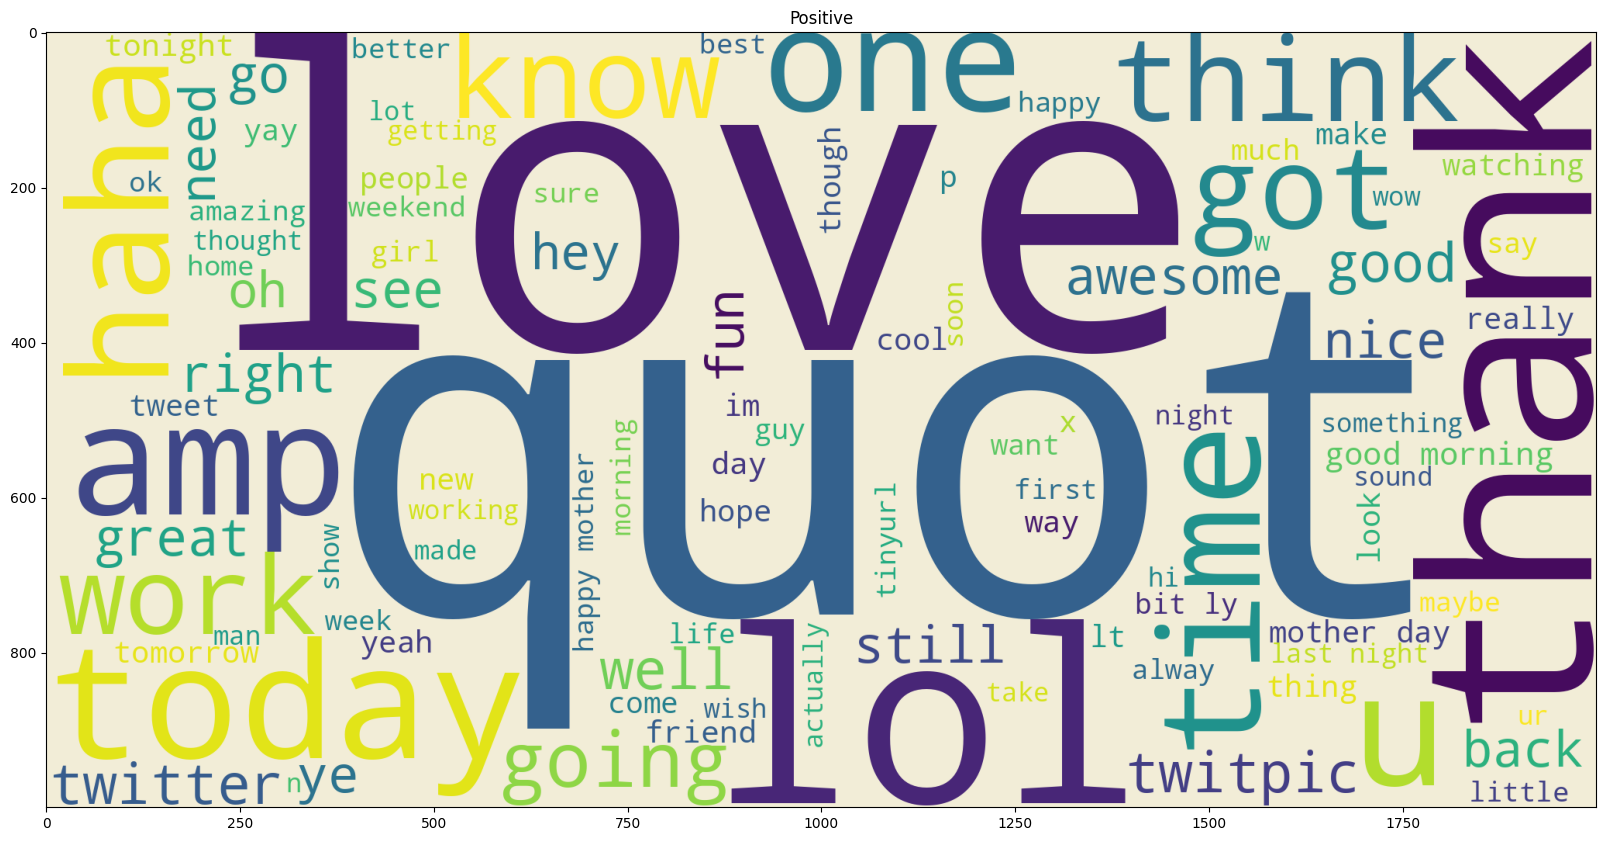

In [30]:
from wordcloud import WordCloud
WordCloud()
wordcloud = WordCloud(width=2000,
                      height=1000,
                      background_color='#F2EDD7FF',
                      max_words = 100).generate(positive_all)

plt.figure(figsize=(20,30))
plt.imshow(wordcloud)
plt.title("Positive")
plt.show()

#### Word CLoud Negative data

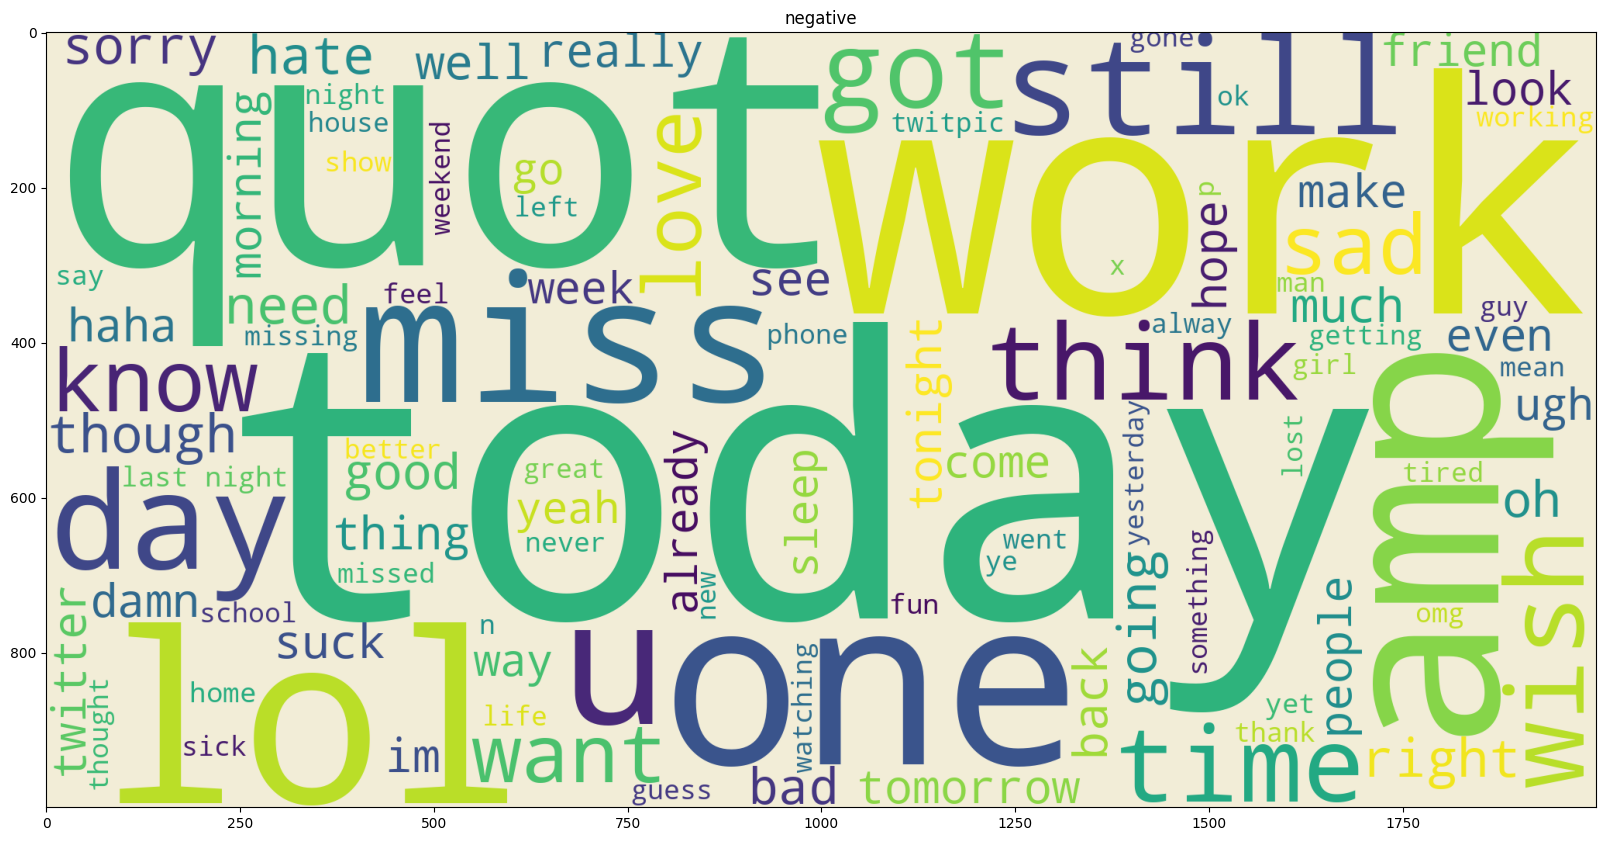

In [31]:
from wordcloud import WordCloud
WordCloud()
wordcloud = WordCloud(width=2000,
                      height=1000,
                      background_color='#F2EDD7FF',
                      max_words = 100).generate(negative_all)

plt.figure(figsize=(20,30))
plt.imshow(wordcloud)
plt.title("negative")
plt.show()

**Inference:**
* Positive data has words like Thank, love , LOL, Haha ets
* Negative data has words like work, sad, tired, suck sorry <br>
Some of the words are still common in both such as Lol, quot

#### One word count

In [32]:
def get_count(data):
    dic = {}
    for i in data:
        for j in i:
            if j not in dic:
                dic[j]=1
            else:
                dic[j]+=1

    return(dic)
count_corpus = get_count(positive_list)

In [33]:
count_corpus = pd.DataFrame({"word":count_corpus.keys(),"count":count_corpus.values()})
count_corpus = count_corpus.sort_values(by = "count", ascending = False)

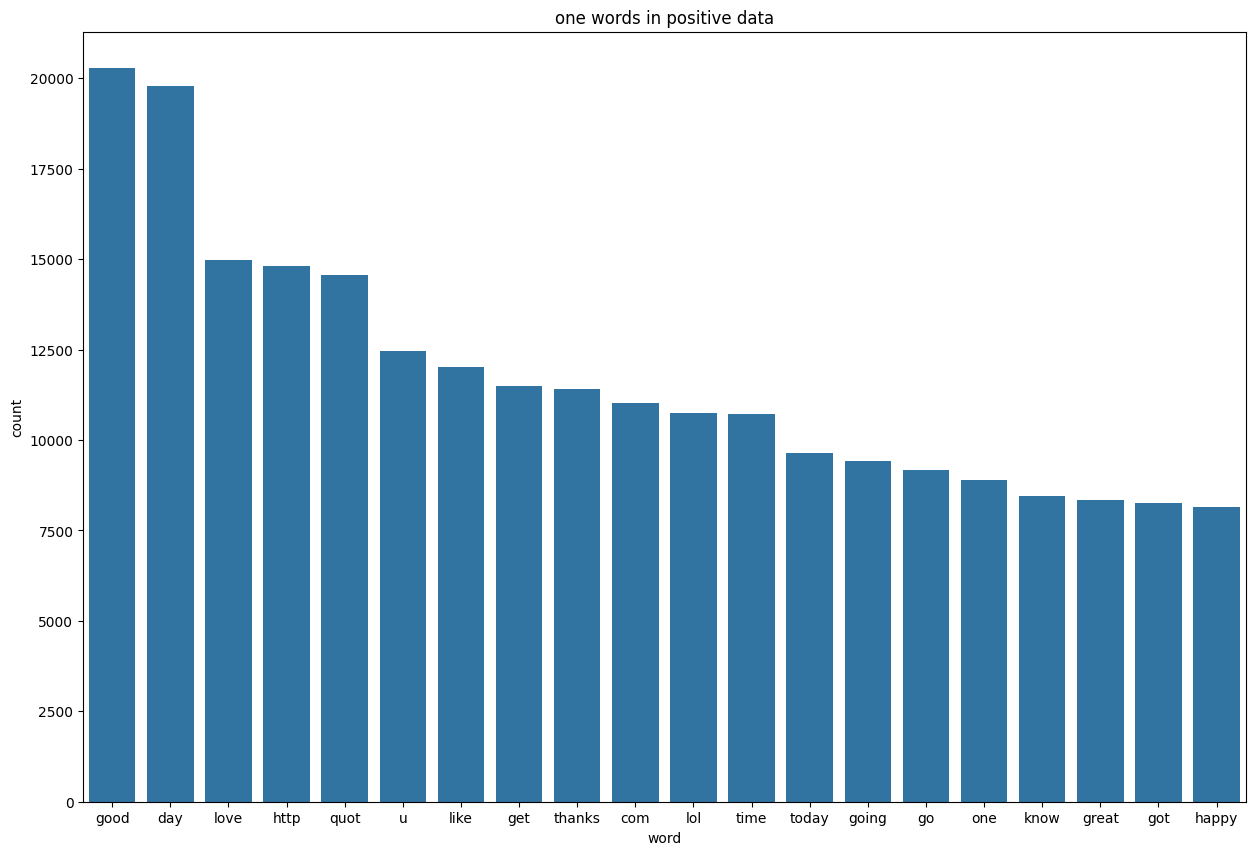

In [34]:
import seaborn as sns
plt.figure(figsize = (15,10))
sns.barplot(x = count_corpus["word"][:20], y = count_corpus["count"][:20])
plt.title('one words in positive data')
plt.show()

In [35]:
def get_count(data):
    dic = {}
    for i in data:
        for j in i:
            if j not in dic:
                dic[j]=1
            else:
                dic[j]+=1

    #dic = dict(sorted(dic.items() , key = lambda x:x[1],reverse=True))
    return(dic)
count_corpus = get_count(negative_list)

In [36]:
count_corpus = pd.DataFrame({"word":count_corpus.keys(),"count":count_corpus.values()})
count_corpus = count_corpus.sort_values(by = "count", ascending = False)

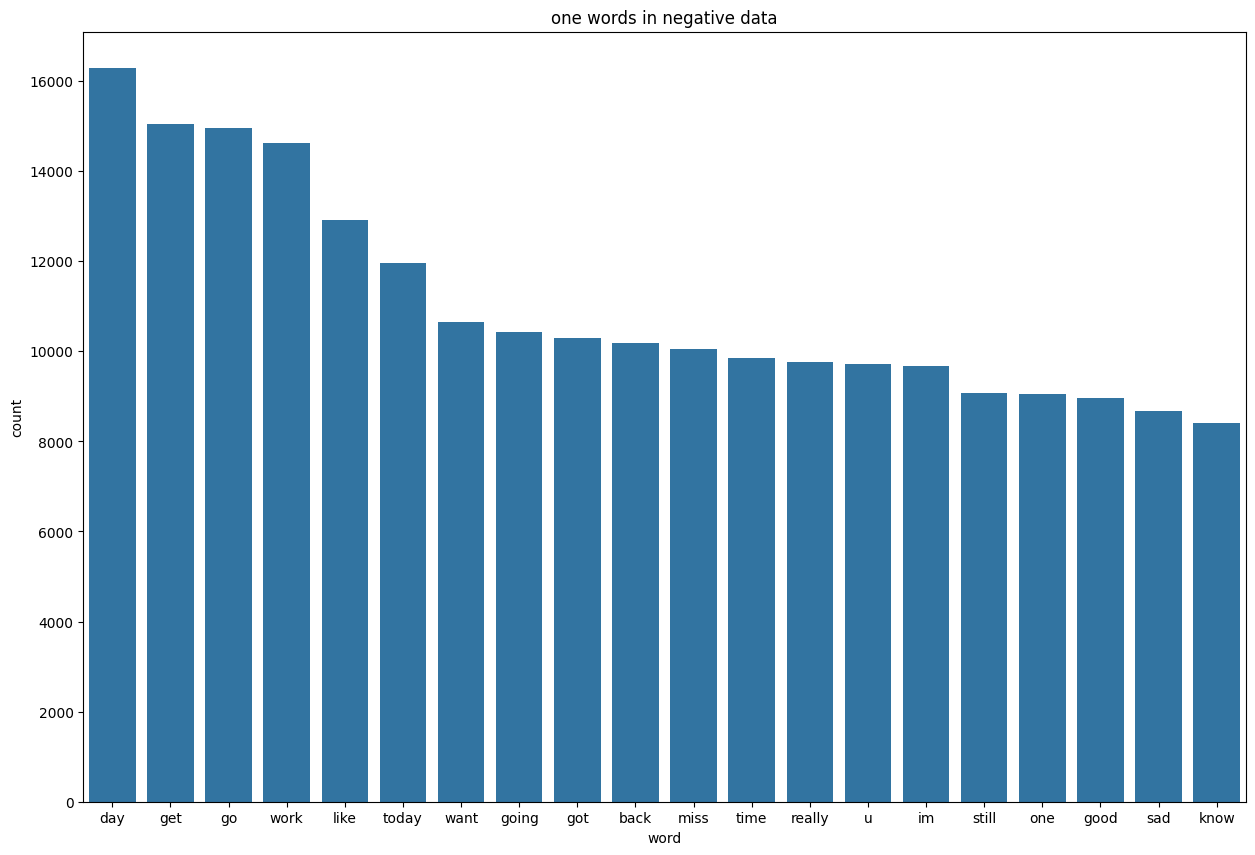

In [37]:
import seaborn as sns
plt.figure(figsize = (15,10))
sns.barplot(x = count_corpus["word"][:20], y = count_corpus["count"][:20])
plt.title('one words in negative data')
plt.show()

**Inference**
* Positive data has words like good, day, thanks, great, happy
* Negative data has words like work, miss, sad etc

## Classification
### Naive bayes for sentiment analysis

In [38]:
def get_tweets_for_model(cleaned_tokens_list):
    for tweet_tokens in cleaned_tokens_list:
        yield dict([token, True] for token in tweet_tokens)

positive_tokens_for_model = get_tweets_for_model(positive_list)
negative_tokens_for_model = get_tweets_for_model(negative_list)

In [39]:
import random

positive_dataset = [(review_dict, "Positive")
                     for review_dict in positive_tokens_for_model]

negative_dataset = [(review_dict, "Negative")
                     for review_dict in negative_tokens_for_model]
dataset = positive_dataset + negative_dataset

random.shuffle(dataset)

train_data = dataset[:333091]
test_data = dataset[333091:]


In [40]:
from nltk import classify
from nltk import NaiveBayesClassifier
classifier = NaiveBayesClassifier.train(train_data)

print(" Training Accuracy is:", round(classify.accuracy(classifier, train_data),2)*100)

print("Testing Accuracy is:", round(classify.accuracy(classifier, test_data),2)*100)

print(classifier.show_most_informative_features(10))

 Training Accuracy is: 86.0
Testing Accuracy is: 77.0
Most Informative Features
                    iran = True           Negati : Positi =     49.4 : 1.0
                  farrah = True           Negati : Positi =     44.2 : 1.0
             squarespace = True           Negati : Positi =     43.8 : 1.0
            followfriday = True           Positi : Negati =     30.4 : 1.0
                   lvatt = True           Negati : Positi =     28.3 : 1.0
                 saddest = True           Negati : Positi =     28.3 : 1.0
         realhughjackman = True           Positi : Negati =     28.2 : 1.0
                hotwords = True           Positi : Negati =     27.7 : 1.0
                  gutted = True           Negati : Positi =     25.1 : 1.0
                     bnp = True           Negati : Positi =     23.0 : 1.0
None


### TFIDF for sentiment analysis

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
vector = tfidf.fit_transform(data_cleaned['text'])
y = data_cleaned['Sentiment']

In [42]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(vector,
                                                    y,
                                                    test_size=0.33,
                                                    random_state=42,
                                                    stratify = y)

In [43]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.linear_model import LogisticRegression

In [44]:
def metrics(y_train,y_train_pred,y_test,y_test_pred):
  print("training accuracy = ",round(accuracy_score(y_train,y_train_pred),2)*100)
  ConfusionMatrixDisplay.from_predictions(y_train,y_train_pred,normalize = 'all')
  print(classification_report(y_train,y_train_pred))
  plt.show()

  print("testing accuracy = ",round(accuracy_score(y_test,y_test_pred),2)*100)
  ConfusionMatrixDisplay.from_predictions(y_test,y_test_pred,normalize = 'all')
  print(classification_report(y_test,y_test_pred))
  plt.show()

### Multinomial NB

training accuracy =  85.0
              precision    recall  f1-score   support

           0       0.83      0.88      0.85    166545
           1       0.87      0.82      0.85    166546

    accuracy                           0.85    333091
   macro avg       0.85      0.85      0.85    333091
weighted avg       0.85      0.85      0.85    333091



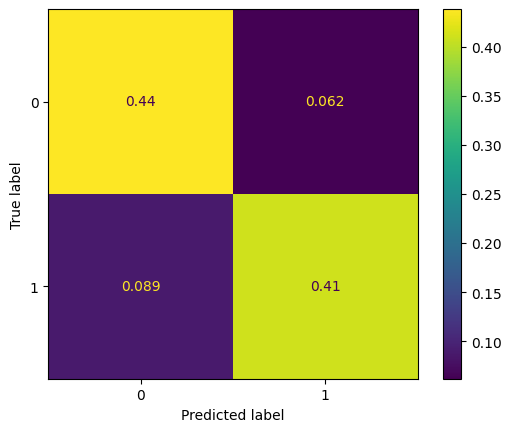

testing accuracy =  76.0
              precision    recall  f1-score   support

           0       0.75      0.80      0.77     82031
           1       0.78      0.73      0.75     82030

    accuracy                           0.76    164061
   macro avg       0.76      0.76      0.76    164061
weighted avg       0.76      0.76      0.76    164061



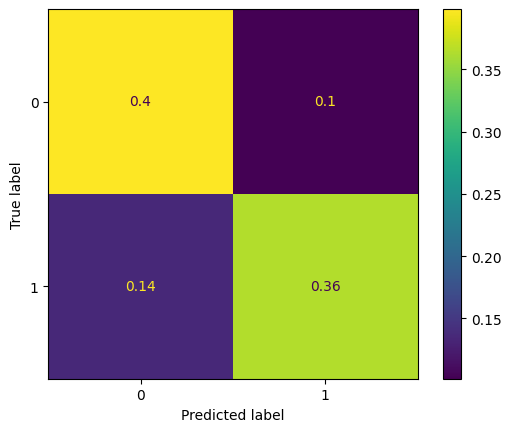

In [45]:
NB = MultinomialNB()
NB.fit(X_train,y_train)
y_train_pred = NB.predict(X_train)
y_test_pred = NB.predict(X_test)
metrics(y_train,y_train_pred,y_test,y_test_pred)

### Linear SVC

training accuracy =  90.0
              precision    recall  f1-score   support

           0       0.90      0.90      0.90    166545
           1       0.90      0.90      0.90    166546

    accuracy                           0.90    333091
   macro avg       0.90      0.90      0.90    333091
weighted avg       0.90      0.90      0.90    333091



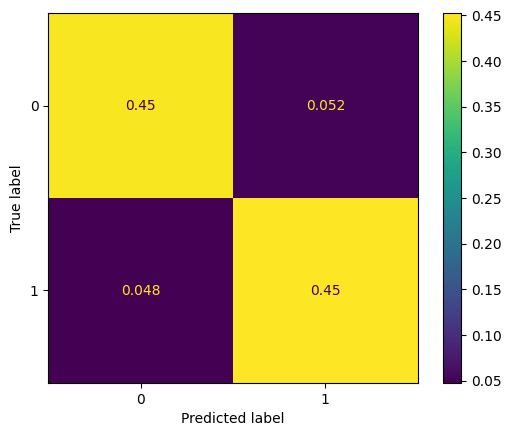

testing accuracy =  77.0
              precision    recall  f1-score   support

           0       0.78      0.76      0.77     82031
           1       0.76      0.78      0.77     82030

    accuracy                           0.77    164061
   macro avg       0.77      0.77      0.77    164061
weighted avg       0.77      0.77      0.77    164061



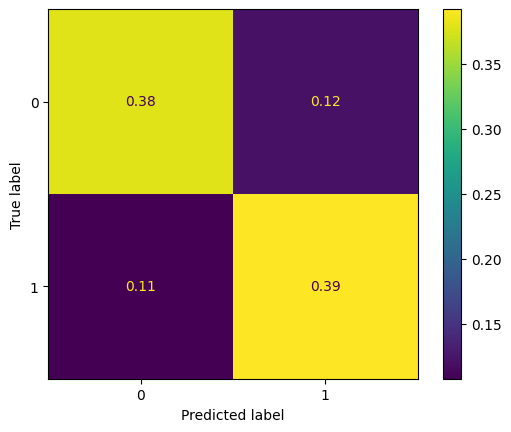

In [46]:
svc = LinearSVC()
svc.fit(X_train,y_train)
y_train_pred = svc.predict(X_train)
y_test_pred = svc.predict(X_test)
metrics(y_train,y_train_pred,y_test,y_test_pred)


### Logistic regression

training accuracy =  83.0
              precision    recall  f1-score   support

           0       0.84      0.81      0.82    166545
           1       0.82      0.84      0.83    166546

    accuracy                           0.83    333091
   macro avg       0.83      0.83      0.83    333091
weighted avg       0.83      0.83      0.83    333091



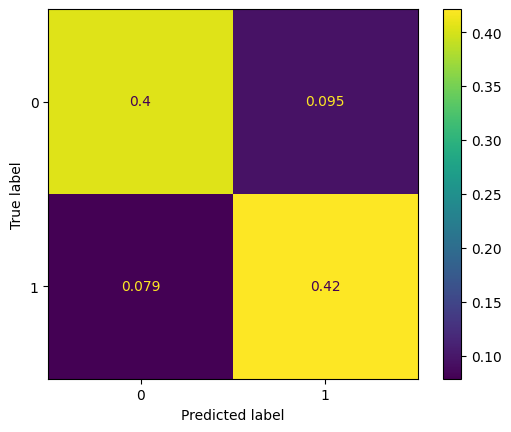

testing accuracy =  78.0
              precision    recall  f1-score   support

           0       0.79      0.75      0.77     82031
           1       0.77      0.80      0.78     82030

    accuracy                           0.78    164061
   macro avg       0.78      0.78      0.78    164061
weighted avg       0.78      0.78      0.78    164061



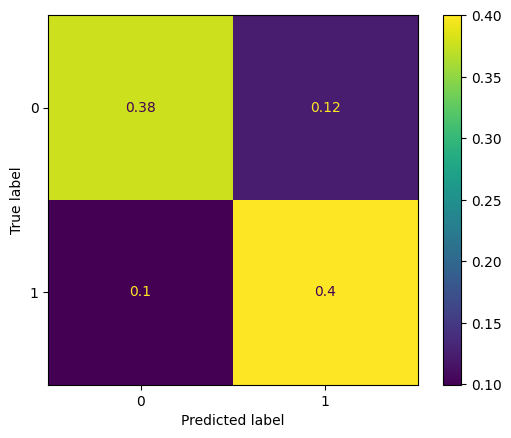

In [47]:
lr = LogisticRegression()
lr.fit(X_train,y_train)
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)
metrics(y_train,y_train_pred,y_test,y_test_pred)

## Conclusion

|Model|Training Accuracy|Testing Accuracy|
|---|---|---|
|Naive Bayes|86%|76%|
|Multinomial NB| 85%|76%|
|linear SVC|90%|77%|
|Logistic|83%|78%|




We see that Logistic regression model performs best with least overfitting as compared to other models and has better performance in testing dataset as well

In [48]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Create your model (replace RandomForestClassifier with your chosen model)
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Define the number of folds for cross-validation
num_folds = 10

# Create a k-fold cross-validation object
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation and get the accuracy scores
cv_scores = cross_val_score(lr, X_train, y_train, cv=kf, scoring='accuracy')

# Display the cross-validation scores
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean Accuracy: {cv_scores.mean()}')
print(f'Standard Deviation: {cv_scores.std()}')


Cross-Validation Scores: [0.77883518 0.77609655 0.77867844 0.77651686 0.77834819 0.77432526
 0.77774776 0.77552613 0.77900868 0.7778078 ]
Mean Accuracy: 0.7772890845261502
Standard Deviation: 0.0015096228889760232


In [49]:
!pip install lime

In [ ]:


import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from lime.lime_text import LimeTextExplainer

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(vector,
#                                                     y,
#                                                     test_size=0.33,
#                                                     random_state=42,
#                                                     stratify = y)

# # Create a TF-IDF vectorizer for text data
vectorizer = TfidfVectorizer(max_features=5000)  # Adjust max_features as needed
# X_train_tfidf = vectorizer.fit_transform(X_train)
# X_test_tfidf = vectorizer.transform(X_test)

# Train a Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Feature Importance Analysis
feature_importances = model.feature_importances_
feature_names = vectorizer.get_feature_names_out()

# Create a DataFrame to display feature importance
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
sorted_feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("Top Features:")
print(sorted_feature_importance_df.head(10))  # Displaying top 10 features

# LIME Explanation for a Sample Instance
explainer = LimeTextExplainer(class_names=['negative', 'positive'])

# Choose a sample text instance for explanation
sample_text_instance = X_test.iloc[0]

# Explain the model's prediction
exp = explainer.explain_instance(sample_text_instance, model.predict_proba, num_features=10)

# Display the explanation
exp.show_in_notebook()
